In [1]:
import pandas as pd

df = pd.read_csv("news_2023_2025_summarized.csv")

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt
import re

In [4]:
# 형태소 분석기 설정
okt = Okt()

# 불용어 정리
with open('stopwords-ko.txt', 'r') as f:
  list_file = f.readlines() 
stopwords_default = [word[:-1] for word in list_file ]
stopwords_default
stopwords = stopwords_default # 기본

# 1. 텍스트 정제 함수 (특수문자, 숫자 제거)
def clean_text(text):
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text) # (), [] 괄호 안 내용 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글과 공백 제외 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 연속 공백 제거
    return text

# 2. 형태소 분석을 통한 명사 추출 함수
def extract_nouns(text):
    nouns = okt.nouns(text)  # 형태소만 추출
    nouns = [word for word in nouns if word not in stopwords and len(word) > 1]  # 불용어 제거 및 한 글자 단어 제외
    return ' '.join(nouns)

# 3. 전체 데이터 전처리
corpus = df['summary'].tolist()
cleaned_corpus = [extract_nouns(clean_text(text)) for text in corpus]  # 정제 + 명사 추출

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import random

# 파라미터 범위 정의
param_grid = {
    'max_df': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_df': [5, 10, 20, 30],
    'max_features': [1000, 2000, 3000]
}

# 랜덤 탐색 기반 평가 함수 정의
def evaluate_vectorizer_params_random(cleaned_corpus, param_grid, n_iter=10, random_state=42):
    random.seed(random_state)
    np.random.seed(random_state)

    results = []

    all_combinations = [
        (max_df, min_df, max_features)
        for max_df in param_grid['max_df']
        for min_df in param_grid['min_df']
        for max_features in param_grid['max_features']
    ]

    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    for max_df, min_df, max_features in sampled_combinations:
        print(f"Testing max_df={max_df}, min_df={min_df}, max_features={max_features}")

        vectorizer = CountVectorizer(
            max_df=max_df,
            min_df=min_df,
            max_features=max_features,
            ngram_range=(1, 2)
        )

        try:
            dtm = vectorizer.fit_transform(cleaned_corpus)
            feature_names = vectorizer.get_feature_names_out()

            lda = LatentDirichletAllocation(
                n_components=10,
                random_state=42,
                max_iter=10
            )

            lda.fit(dtm)
            perplexity = lda.perplexity(dtm)

            results.append({
                'max_df': max_df,
                'min_df': min_df,
                'max_features': max_features,
                'vocabulary_size': len(feature_names),
                'perplexity': perplexity,
                'log_likelihood': lda.score(dtm)
            })
        except Exception as e:
            print(f"Error with parameters: {e}")

    return pd.DataFrame(results)

# 평가 실행
results_df = evaluate_vectorizer_params_random(cleaned_corpus, param_grid, n_iter=10)

# 결과 정렬 및 출력
results_df = results_df.sort_values(by='perplexity')
print("\n최적의 벡터라이저 파라미터 (perplexity 기준):")
print(results_df.head())

# 최적의 파라미터 추출
best_params = results_df.iloc[0][['max_df', 'min_df', 'max_features']].to_dict()
print(f"\n최적의 파라미터: {best_params}")


Testing max_df=0.8, min_df=10, max_features=2000
Testing max_df=0.5, min_df=20, max_features=2000
Testing max_df=0.5, min_df=5, max_features=2000
Testing max_df=0.8, min_df=30, max_features=3000
Testing max_df=0.6, min_df=10, max_features=3000
Testing max_df=0.6, min_df=10, max_features=1000
Testing max_df=0.6, min_df=5, max_features=3000
Testing max_df=0.5, min_df=20, max_features=3000
Testing max_df=0.9, min_df=20, max_features=3000
Testing max_df=0.5, min_df=20, max_features=1000

최적의 벡터라이저 파라미터 (perplexity 기준):
   max_df  min_df  max_features  vocabulary_size  perplexity  log_likelihood
5     0.6      10          1000             1000  465.816920   -1.507613e+06
9     0.5      20          1000             1000  465.816920   -1.507613e+06
3     0.8      30          3000             1977  736.254195   -1.905815e+06
0     0.8      10          2000             2000  737.877779   -1.912765e+06
1     0.5      20          2000             2000  745.621200   -1.915755e+06

최적의 파라미터: {'max_

In [6]:
# CountVectorizer로 전처리한 기사 텍스트를 빈도수 기반 단어 추출
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_df=0.6,  # 전체 문서의 80% 이상 등장한 단어 제외
    min_df=10,    # Minimum Document Frequency, 최소 문서 빈도 = min_df=5면 최소 5개 문서에서 등장해야 포함됨
    max_features=1000,
    ngram_range=(1, 3),  # unigram + bigram + trigram 사용
    token_pattern=r'\b\w+\b'  # 숫자 포함 단어도 추출 가능
)

dtm = vectorizer.fit_transform(cleaned_corpus)  # 전처리된 데이터로 DTM 생성
dtm.shape

# 추출된 단어 리스트 출력
words = vectorizer.get_feature_names_out()
print("✅ 추출된 키워드 목록:", words[:1000])

✅ 추출된 키워드 목록: ['가격' '가격 상승' '가능성' '가동' '가량' '가맹' '가속' '가스' '가시' '가운데' '가장' '가전' '가지'
 '가치' '가치 계획' '가치 위해' '감사' '감소' '감안' '강조' '강화' '개발' '개선' '개선 전망' '개시' '개월'
 '개인' '개최' '개편' '갤럭시' '거래' '거래소' '건강' '건설' '검토' '게임' '견인' '견조' '결과' '결의'
 '결정' '결정 공시' '결제' '결합' '경기' '경신' '경영' '경영 분쟁' '경우' '경쟁' '경쟁력' '경제' '경험'
 '계속' '계약' '계약 체결' '계열' '계좌' '계획' '계획 발표' '고가' '고객' '고객 대상' '고려' '고려아연'
 '공개' '공개매수' '공급' '공급 계약' '공급 계약 체결' '공동' '공략' '공모' '공사' '공시' '공시 통해' '공식'
 '공장' '공정' '과거' '과정' '관계' '관계자' '관광' '관광 개발' '관련' '관리' '관사' '관세' '관세 부과'
 '관심' '관점' '관측' '광고' '교보' '교보 증권' '교육' '교체' '구간' '구매' '구성' '구조' '구체' '구축'
 '국가' '국내' '국내외' '국제' '규모' '규모 사주' '규제' '그룹' '그룹 회장' '글로벌' '글로벌 시장' '금리'
 '금액' '금융' '금융 지주' '금융감독원' '금융감독원 자공시' '금융감독원 자공시 시스템' '금융투자' '금지' '금호'
 '급등' '급락' '급증' '긍정' '기간' '기계' '기관' '기기' '기능' '기대' '기대 분석' '기록' '기반' '기술'
 '기아' '기업' '기업 가치' '기업 가치 계획' '기업 공개' '기업 밸류업' '기업가' '기업인' '기여' '기적' '기조'
 '기존' '기준' '기회' '꼽았다' '납품' '내년' '내용' '네이버' '넥스' '넷마블' '노력' '논의' '누적' '뉴진스'
 '능력' '다시' '단계' '단기' '달러' '달성' '

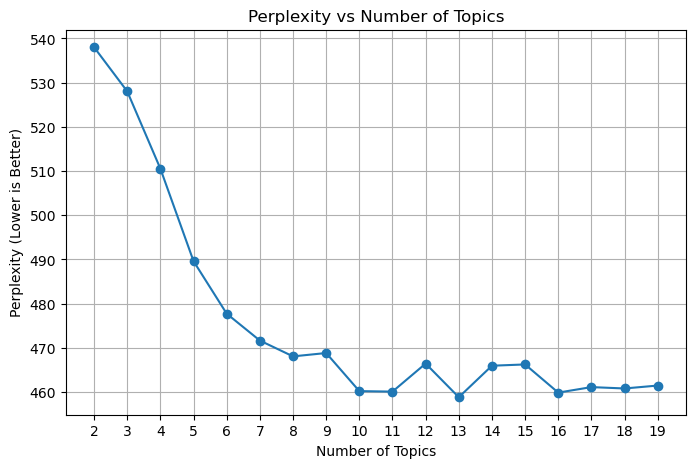

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

# 2. 최적 토픽 개수 찾기
perplexities = []
topic_range = range(2, 20)  # 토픽 개수 2개 ~ 16개 테스트

for n_topics in topic_range:
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        doc_topic_prior=0.1,
        # topic_word_prior=0.01,
        max_iter=10,  # 충분한 학습 횟수
        learning_method='batch',  # 안정적인 batch 학습
        random_state=42,
        n_jobs=-1  # 병렬 처리
    )
    lda.fit(dtm)
    perplexities.append(lda.perplexity(dtm))  # perplexity 저장

# 3. Perplexity 시각화
plt.figure(figsize=(8, 5))
plt.plot(topic_range, perplexities, marker='o', linestyle='-')
plt.title('Perplexity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity (Lower is Better)')
plt.xticks(topic_range)
plt.grid()
plt.show()

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# 사용자 정의 scorer: 음의 perplexity를 반환 (낮은 perplexity가 좋은 모델이므로)
def neg_perplexity_scorer(estimator, X):
    return -estimator.perplexity(X)

# 또는 make_scorer를 사용해 scorer 생성
scorer = make_scorer(neg_perplexity_scorer, greater_is_better=True)

# LDA 하이퍼파라미터 후보 설정
param_grid_lda = {
    'n_components': [9,10,11],  # 앞서 perplexity 결과에서 적정 범위
    'doc_topic_prior': [0.2, 0.3, 0.4],
    'topic_word_prior': [0.01, 0.1, 0.5],
    'max_iter': [10, 20]
}

# LDA 모델 생성 (learning_method='batch'로 안정적인 학습)
lda = LatentDirichletAllocation(
    learning_method='batch',
    random_state=42,
    n_jobs=-1
)


# RandomizedSearchCV로 최적의 하이퍼파라미터 탐색
random_search_lda = RandomizedSearchCV(
    lda,
    param_distributions=param_grid_lda,  # param_grid_lda 그대로 사용 가능
    n_iter=10,  # 몇 번 시도할지 (ex: 10번만 랜덤 조합 탐색)
    scoring=scorer,
    cv=3,
    verbose=2,
    random_state=42
)

# 실행
random_search_lda.fit(dtm)


# 최적의 파라미터 및 결과 출력
print("최적의 LDA 모델 하이퍼파라미터:")
print(random_search_lda.best_params_)
print("\n최적의 점수 (음의 perplexity):")
print(random_search_lda.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\ilhoo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ilhoo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END doc_topic_prior=0.3, max_iter=10, n_components=9, topic_word_prior=0.1; total time=  17.3s
[CV] END doc_topic_prior=0.3, max_iter=10, n_components=9, topic_word_prior=0.1; total time=  19.1s
[CV] END doc_topic_prior=0.3, max_iter=10, n_components=9, topic_word_prior=0.1; total time=  17.1s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.1; total time=  29.3s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.1; total time=  29.1s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.1; total time=  30.0s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.01; total time=  28.7s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.01; total time=  25.0s
[CV] END doc_topic_prior=0.4, max_iter=20, n_components=10, topic_word_prior=0.01; total time=  26.6s
[CV] END doc_topic_prior=0.2, max_iter=20, n_components=10, topic_word_prior=0.01; total ti

c:\Users\ilhoo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


최적의 LDA 모델 하이퍼파라미터:
{'topic_word_prior': 0.1, 'n_components': 9, 'max_iter': 10, 'doc_topic_prior': 0.3}

최적의 점수 (음의 perplexity):
nan


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import pprint

# 최적의 하이퍼파라미터로 LDA 모델 학습 (토픽 수 7개)
lda = LatentDirichletAllocation(
    n_components=9, 
    doc_topic_prior=0.3, 
    topic_word_prior=0.1,
    max_iter=10,
    learning_method='batch',
    random_state=42
)
lda.fit(dtm)


# 토픽 이름: 실제 토픽 수에 맞춰 "토픽 1" ~ "토픽 7" 사용
topic_names = [f'토픽 {i}' for i in range(1, 10)]
terms = vectorizer.get_feature_names_out()
topic_keywords = {}

# 토픽별 상위 10개 키워드 추출
for i, topic in enumerate(lda.components_):
    top_keywords = [terms[j] for j in topic.argsort()[-10:][::-1]]
    topic_keywords[topic_names[i]] = top_keywords

# 각 기사별 토픽 분포 (토픽 점수) 계산
doc_topic = lda.transform(dtm)

results = []
for i, topic_dist in enumerate(doc_topic):
    top_topic = topic_dist.argmax()
    result = {
        '기사 번호': i + 1,
        '주요 토픽': topic_names[top_topic],
    }
    # 각 토픽에 대한 점수를 소수점 4자리로 반올림하여 결과에 추가
    result.update({topic_names[j]: round(topic_dist[j], 4) for j in range(len(topic_names))})
    results.append(result)

df_results = pd.DataFrame(results)

# 결과 출력
print("\n[토픽별 주요 키워드]")
pprint.pprint(topic_keywords)

print("\n[기사별 주요 토픽 점수]")
df_results.head()


[토픽별 주요 키워드]
{'토픽 1': ['시장', '글로벌', '계약', '공급', '출시', '제품', '게임', '국내', '체결', '업체'],
 '토픽 2': ['실적', '증권', '분기', '전망', '대해', '분석', '올해', '예상', '성장', '분기 실적'],
 '토픽 3': ['실적', '분기', '개선', '주가', '목표', '롯데', '전망', '올해', '기록', '실적 개선'],
 '토픽 4': ['투자', '투자 증권', '증권', '한국', '사업', '성장', '카카오', '대해', '에너지', '분석'],
 '토픽 5': ['미국', '정책', '사업', '환원', '삼성', '현대차', '매각', '대표', '관세', '주주'],
 '토픽 6': ['기업', '한화', '바이오', '개발', '사업', '하이브', '기술', '계획', '생산', '솔루션'],
 '토픽 7': ['주가', '반도체', '하이닉스', '상승', '하락', '가운데', '최근', '지능', '외국인', '인공'],
 '토픽 8': ['증권', '금융', '고객', '서비스', '미래에셋', '투자', '주식', '미래에셋 증권', '대상', '제공'],
 '토픽 9': ['억원', '주주', '그룹', '사주', '공시', '규모', '경영', '주식', '회장', '매입']}

[기사별 주요 토픽 점수]


,기사 번호,주요 토픽,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9
0,1,토픽 5,0.0192,0.0170,0.0174,0.3713,0.4994,0.0197,0.0177,0.0200,0.0183
1,2,토픽 9,0.0144,0.0139,0.0140,0.1949,0.2023,0.1788,0.0145,0.1455,0.2217
2,3,토픽 5,0.0168,0.0190,0.0184,0.3996,0.4220,0.0169,0.0164,0.0175,0.0734
3,4,토픽 9,0.0206,0.0204,0.2111,0.0249,0.0223,0.0208,0.0972,0.0219,0.5608
4,5,토픽 4,0.1878,0.0234,0.0219,0.3073,0.2077,0.0216,0.0191,0.1924,0.0188


토픽 1: 글로벌 시장 및 계약 동향

글로벌 시장 진출, 공급 계약, 신제품 출시, 게임 및 국내외 업체 동향 등 시장 확장과 계약 체결 관련 이슈가 중심입니다.

토픽 2: 증권사 실적 및 분기 전망

증권사와 관련된 분기 실적, 성장 전망, 올해 예상 실적 분석 등 증권업계의 실적 및 전망에 초점이 맞춰져 있습니다.

토픽 3: 기업 실적 개선 및 주가 전망

롯데 등 주요 기업의 분기 실적 개선, 주가 목표, 실적 기록 등 실적 개선과 주가 전망이 주요 키워드입니다.

토픽 4: 투자 및 증권사 사업 분석

투자, 투자 증권, 사업 성장, 카카오 및 에너지 사업 등 투자와 관련된 증권사 분석 및 사업 성장에 관한 내용입니다.

토픽 5: 미국 정책 및 대기업 사업 전략

미국 정책, 삼성·현대차 등 대기업의 사업 구조조정, 관세, 주주 환원 등 글로벌 정책과 대기업 전략에 관한 주제입니다.

토픽 6: 기업 기술 개발 및 바이오 산업

한화, 바이오, 하이브 등 기업의 기술 개발, 생산 계획, 솔루션 등 첨단 산업 및 신사업 개발 동향입니다.

토픽 7: 반도체 및 AI 관련 주가 동향

반도체, 하이닉스, 인공지능, 외국인 투자 등 반도체 산업과 AI 관련 주가 상승·하락 동향입니다.

토픽 8: 금융 서비스 및 고객 투자

미래에셋 등 증권사의 금융 서비스, 고객 대상 투자 상품, 주식 제공 등 금융 서비스 혁신과 투자 확대가 중심입니다.

토픽 9: 대규모 주주 및 경영 이슈

주주, 그룹, 사주, 공시, 경영, 회장 등 대규모 자금, 주식 매입, 경영권 이슈 등 기업 지배구조 및 주주 관련 이슈입니다.

In [10]:
import joblib

joblib.dump(vectorizer, 'count_vectorizer.pkl')
joblib.dump(lda, 'best_lda_model.pkl')
joblib.dump(dtm, 'document_term_matrix.pkl')
joblib.dump(results_df, 'grid_search_results.pkl')

['grid_search_results.pkl']

# 최종 

In [13]:
import joblib
import re
from konlpy.tag import Okt
import pandas as pd
import numpy as np

def predict_topic_for_df(
    df,
    model_path='best_lda_model.pkl',
    vectorizer_path='count_vectorizer.pkl',
    stopwords_path='stopwords-ko.txt',
    summary_col='summary',
    news_id_col='news_id',
    n_topics=9
):
    # 1. 저장된 벡터라이저와 LDA 모델 불러오기
    vectorizer = joblib.load(vectorizer_path)
    lda_model = joblib.load(model_path)

    # 2. 형태소 분석기 및 불용어 로드
    okt = Okt()
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stopwords = [word.strip() for word in f.readlines()]

    # 3. 텍스트 정제 함수
    def clean_text(text):
        text = re.sub(r'\[.*?\]|\(.*?\)', '', text)
        text = re.sub(r'[^가-힣\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # 4. 명사 추출 함수
    def extract_nouns(text):
        nouns = okt.nouns(text)
        nouns = [word for word in nouns if word not in stopwords and len(word) > 1]
        return ' '.join(nouns)

    # 5. 데이터 전처리 (정제 + 명사 추출)
    processed_texts = [extract_nouns(clean_text(text)) for text in df[summary_col]]

    # 6. 벡터라이즈 (DTM 생성)
    new_dtm = vectorizer.transform(processed_texts)

    # 7. LDA 토픽 분포 예측
    topic_distribution = lda_model.transform(new_dtm)
    dominant_topic = topic_distribution.argmax(axis=1)

    # 8. 결과 DataFrame 생성 (news_id, 주요 토픽, 토픽1~토픽n)
    topic_columns = ['주요 토픽'] + [f'토픽 {i+1}' for i in range(n_topics)]
    topic_data = np.concatenate([dominant_topic.reshape(-1, 1), topic_distribution], axis=1)
    topic_df = pd.DataFrame(topic_data, columns=topic_columns)
    topic_df[news_id_col] = df[news_id_col].values

    # 9. news_id 기준으로 merge
    result_df = pd.merge(df, topic_df, on=news_id_col, how='left')

    return result_df

# 테스트

In [14]:
if __name__ == "__main__":
    
    df = pd.read_csv("news_2023_2025_summarized.csv")
    df = df[:][1234:1244]

    result = predict_topic_for_df(df)
    result

In [25]:
result

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,주요 토픽,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9
0,20250408_0153,2025-04-08 07:44:00,"카카오 ""특별한 해결책 나오기 힘들다""…목표가 4만9000원-한투",한국투자증권은 카카오가 올해 실적 개선폭이 다소 제한적일 것으로 8일 분석했다. 다...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://ssl.pstatic.net/static.news/image/news...,한국투자증권은 카카오가 올해 실적 개선폭이 다소 제한적일 것으로 8일 분석했다. 다...,한국투자증권은 카카오가 올해 실적 개선폭이 다소 제한적일 것으로 8일 분석하고 오픈...,['카카오'],"['자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업']","[-0.00929342582821846, -0.9733307361602783, 0....",3.0,0.015231,0.227417,0.107208,0.450434,0.013072,0.013372,0.012312,0.148332,0.012623
1,20250408_0155,2025-04-08 07:41:00,"현대차, 올해 영업익에 관세 비용 2.4조 반영…목표가↓-SK",[이데일리 신하연 기자] SK증권은 현대차(005380)에 대해 2분기 실적부터 관...,이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/04/...,"이어 “단기적으로는 인센티브 감소, 혜택 축소 등 비 가격적인 인상 요인으로 영향을...",현대차의 미국 시장 점유율 수성에 비용 증가가 필연적일 것으로 전망하며 우호적인 주...,['현대차'],['자동차용 엔진 및 자동차 제조업'],"[-0.5147978067398071, -0.28462550044059753, 0....",4.0,0.015324,0.337113,0.133161,0.012418,0.452539,0.012253,0.012387,0.012370,0.012434
2,20250408_0158,2025-04-08 07:36:00,"""기아, 관세 반영해도 PER 4배…목표가는 '하향'""-SK",기아 멕시코 공장에서 200만번째로 생산된 올 뉴 K4/사진=기아\nSK증권은 8일...,한국경제,https://n.news.naver.com/mnews/article/015/000...,https://imgnews.pstatic.net/image/015/2025/04/...,기아 멕시코 공장에서 200만번째로 생산된 올 뉴 K4=기아 SK증권은 8일 기아에...,"8일 기아 SK증권은 8일 기아에 대해 ""최근 관세 노이즈를 반영해도 주가수익비율(...",['기아'],['자동차용 엔진 및 자동차 제조업'],"[-0.4138392508029938, -0.15561288595199585, -0...",1.0,0.096101,0.405865,0.184986,0.007014,0.166975,0.007012,0.007294,0.035288,0.089465
3,20250408_0160,2025-04-08 07:25:00,"""반도체 관세, 美에도 부정적…반등 국면에선 SK하이닉스 유리""-NH",사진=연합뉴스\nNH투자증권은 8일 도널드 트럼프 미국 대통령의 품목관세 발표를 앞...,한국경제,https://n.news.naver.com/mnews/article/015/000...,https://imgnews.pstatic.net/image/015/2025/04/...,사진=연합뉴스 NH투자증권은 8일 도널드 트럼프 미국 대통령의 품목관세 발표를 앞두...,NH투자증권은 8일 도널드 트럼프 미국 대통령의 품목관세 발표를 앞두고 있는 반도체...,['NH투자증권'],['금융 지원 서비스업'],"[0.2964267432689667, -0.3285354971885681, 0.03...",4.0,0.008006,0.127987,0.009172,0.149693,0.505114,0.008125,0.176503,0.007807,0.007593
4,20250408_0162,2025-04-08 06:41:00,"창립 72주년 맞는 SK, 창업정신 기리며 '삼각파도' 극복 나서",1953년 직물로 시작…정유·정보통신·반도체에 이어 AI까지 '혁신'으로 위기 극복...,연합뉴스,https://n.news.naver.com/mnews/article/001/001...,https://imgnews.pstatic.net/image/001/2025/04/...,1953년 직물로 시작…정유·정보통신·반도체에 이어 AI까지 '혁신'으로 위기 극복...,SK그룹이 창립 72주년을 맞아 고(故) 최종건 창업회장과 고 최종현 선대회장을 기...,['SK'],['기타 금융업'],"[-0.39478760957717896, -0.3380502164363861, 0....",8.0,0.018274,0.018315,0.018264,0.018088,0.019052,0.018416,0.023559,0.018005,0.848026
5,20250407_0002,2025-04-07 18:44:00,"유안타증권, 산불 피해 복구 기부금 1억 전달",유안타증권은 최근 경상도 지역에서 발생한 대규모 산불 피해 복구를 위한 기부금 1억...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://ssl.pstatic.net/static.news/image/news...,유안타증권은 최근 경상도 지역에서 발생한 대규모 산불 피해 복구를 위한 기부금 1억...,유안타증권은 갑작스러운 재난으로 혼란에 빠진 지역 및 주민들을 지원해 빠르게 정상적...,['유안타증권'],['금융 지원 서비스업'],"[0.034449703991413116, -1.0671734809875488, 0....",7.0,0.021967,0.021865,0.022423,0.164709,0.020890,0.021567,0.020931,0.611791,0.093857
6,20250407_0012,2025-04-07 16:40:00,"유진투자증권, 해외주식 이벤트 진행...최대 150만원 혜택",해외주식 최초 거래 신청 시 7개월간 미국주식 수수료 완전 무료\n해외주식 순입고 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2025/04/...,사내 모델이 해당 이벤트를 안내하고 있다. 유진투자증권 제공 유진투자증권이 해외주...,7일 유진투자증권은 타 금융사에서 유진투자증권으로 해외주식을 옮기는 고객에게는 순입...,['유진투자증권'],['금융 지원 서비스업'],"[-0.886139988899231, -0.560568630695343, 0.104...",7.0,0.010236,0.009860,0.010725,0.445207,0.010000,0.010662,0.009983,0.482617,0.010709
7,20250407_0014,2025-04-07 16:37:00,"SK증권, 고객 소통 강화 위한 릴레이 문화 세미나 성료",지역별 거점 대형금융센터 출범 기념\n우수고객 초청 문화 세미나 개최\nSK증권이 ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/04/...,지역별 거점 대형금융센터 출범 기념 우수고객 초청 문화 세미나 개최 SK증권이 올해...,SK증권이 올해 초 대형금융센터 출범을 기념해 지난 1월부터 3월까지 주요 거점 점...,['SK증권'],['금융 지원 서비스업'],"[-1.2372506856